In [1]:
# Fringe pattern demo for a simple interferometry toy model
#
# What this does
# 1) Builds a 1D and 2D "sky" image with one or more point sources (delta functions) in Jy.
# 2) Computes the Fourier Transform (the "visibility" function) and shows the resulting fringes.
# 3) Lets you tweak separations/fluxes and immediately see how the fringe spacing changes.
#
# Notes
# - Axes are in arbitrary angular units; the FT axes correspond to spatial frequency u (wavelength^-1).
# - One equal-brightness pair gives pure cosinusoidal fringes whose spacing ~ 1/(angular separation).
#
# You can re-run the last cell to experiment with different parameters.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# ---------- Helper functions ----------

def make_1d_sky(n=2048, sep_pixels=200, flux_jy=(1.0, 1.0)):
    """
    Make a 1D "sky" with either one or two point sources.
    - n: samples across the field
    - sep_pixels: separation between the two sources in pixels (set 0 to get a single source)
    - flux_jy: tuple of flux densities (Jy). If len=1 -> single source at center.
               If len=2 -> two sources placed symmetrically about center.
    Returns:
        x (angle index), I (intensity in Jy), meta dict
    """
    I = np.zeros(n, dtype=float)
    cx = n // 2
    if len(flux_jy) == 1 or sep_pixels == 0:
        I[cx] = flux_jy[0]
        meta = {"n_src": 1, "sep_px": 0}
    else:
        half = sep_pixels // 2
        I[cx - half] = flux_jy[0]
        I[cx + half] = flux_jy[1]
        meta = {"n_src": 2, "sep_px": sep_pixels}
    x = np.arange(n) - cx
    return x, I, meta


def vis_ft_1d(I):
    """Return Fourier transform (shifted) of a 1D image I."""
    V = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(I)))
    return V


def make_2d_sky(n=512, sep_pixels=60, flux_jy=(1.0, 1.0)):
    """
    2D "sky" with one or two point sources separated along x.
    """
    I = np.zeros((n, n), dtype=float)
    cx = cy = n // 2
    if len(flux_jy) == 1 or sep_pixels == 0:
        I[cy, cx] = flux_jy[0]
        meta = {"n_src": 1, "sep_px": 0}
    else:
        half = sep_pixels // 2
        I[cy, cx - half] = flux_jy[0]
        I[cy, cx + half] = flux_jy[1]
        meta = {"n_src": 2, "sep_px": sep_pixels}
    return I, meta


def vis_ft_2d(I2):
    """Return 2D Fourier transform (shifted) of a 2D image I2."""
    V2 = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(I2)))
    return V2

In [4]:
# ---------- 1D demo: single source vs two sources ----------

# Parameters you can tweak
n1d = 2048           # grid size (pixels/samples)
sep_px = 300         # pixel separation between the two sources
flux_pair = (1.0, 1.0)  # Jy for the two sources
flux_single = (1.0,)    # Single 1 Jy source

In [5]:
# Build skies
x1, I_single, meta_single = make_1d_sky(n=n1d, sep_pixels=0, flux_jy=flux_single)
x2, I_pair, meta_pair = make_1d_sky(n=n1d, sep_pixels=sep_px, flux_jy=flux_pair)

# Fourier transforms ("visibilities")
V_single = vis_ft_1d(I_single)
V_pair   = vis_ft_1d(I_pair)

# "u" axis (spatial frequency). Units are inverse pixels (arbitrary scaling).
u = np.fft.fftshift(np.fft.fftfreq(n1d, d=1.0))

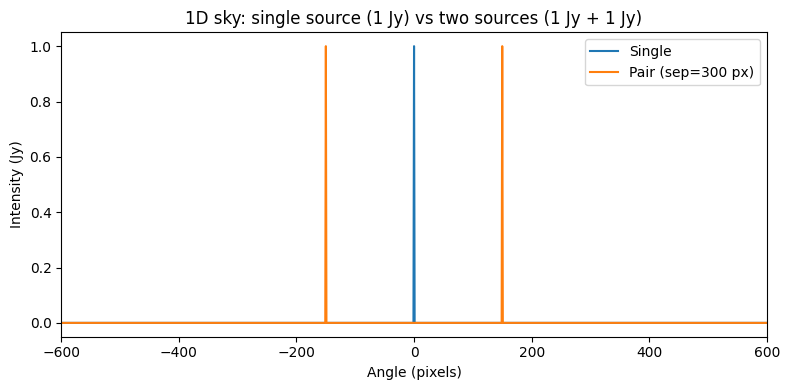

In [6]:
# Plot: image domain
plt.figure(figsize=(8, 4))
plt.title("1D sky: single source (1 Jy) vs two sources (1 Jy + 1 Jy)")
plt.plot(x1, I_single, label="Single")
plt.plot(x2, I_pair, label=f"Pair (sep={sep_px} px)")
plt.xlabel("Angle (pixels)")
plt.ylabel("Intensity (Jy)")
plt.xlim(-sep_px*2, sep_px*2)
plt.legend()
plt.tight_layout()
plt.show()

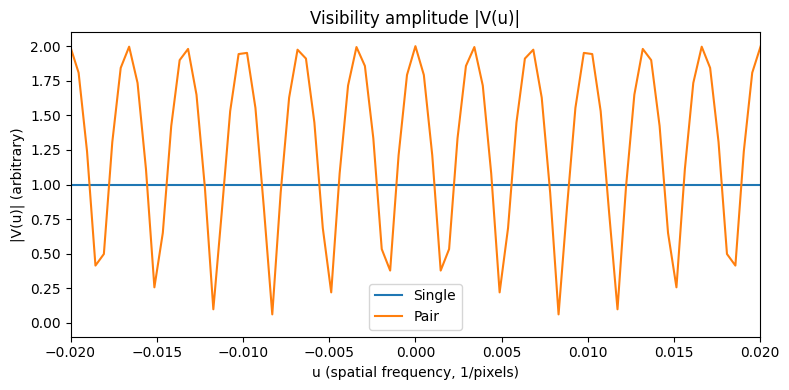

In [7]:
# Plot: visibility amplitude
plt.figure(figsize=(8, 4))
plt.title("Visibility amplitude |V(u)|")
plt.plot(u, np.abs(V_single), label="Single")
plt.plot(u, np.abs(V_pair), label="Pair")
plt.xlabel("u (spatial frequency, 1/pixels)")
plt.ylabel("|V(u)| (arbitrary)")
plt.xlim(-0.02, 0.02)  # zoom near DC so fringes are visible
plt.legend()
plt.tight_layout()
plt.show()

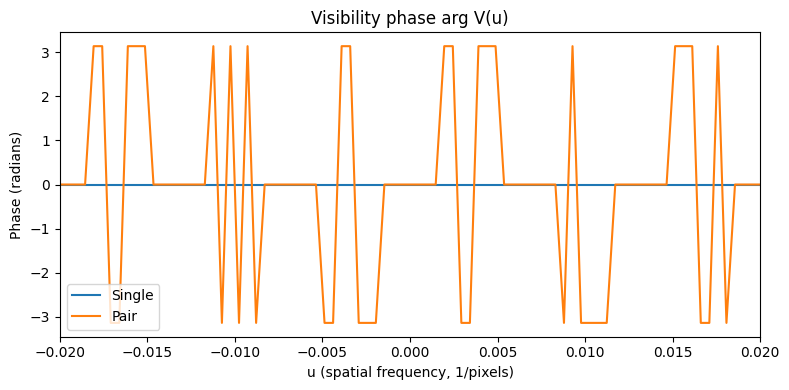

In [8]:
# Plot: visibility phase
plt.figure(figsize=(8, 4))
plt.title("Visibility phase arg V(u)")
plt.plot(u, np.angle(V_single), label="Single")
plt.plot(u, np.angle(V_pair), label="Pair")
plt.xlabel("u (spatial frequency, 1/pixels)")
plt.ylabel("Phase (radians)")
plt.xlim(-0.02, 0.02)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# Estimate fringe spacing from the two-source |V(u)| pattern
# For two equal deltas separated by Δx, |V(u)| ∝ 2|cos(π u Δx)|
# Fringe period in u is Δu ≈ 1/Δx (in these pixel units).
delta_x = sep_px
fringe_period_u = 1.0 / delta_x if delta_x != 0 else np.nan
print(f"Estimated fringe period Δu ≈ 1/Δx = {fringe_period_u:.6f} (1/pixels)")

Estimated fringe period Δu ≈ 1/Δx = 0.003333 (1/pixels)


In [10]:
# ---------- 2D demo: stripes in the 2D visibility ----------

n2d = 512
sep_px_2d = 80
I2_single, _ = make_2d_sky(n=n2d, sep_pixels=0, flux_jy=(1.0,))
I2_pair, _   = make_2d_sky(n=n2d, sep_pixels=sep_px_2d, flux_jy=(1.0, 1.0))

V2_single = vis_ft_2d(I2_single)
V2_pair   = vis_ft_2d(I2_pair)

In [13]:
# Show 2D images and 2D |V| (log scale for visibility magnitude)
def imshow_centered(img, title, vmin=None, vmax=None, log=False):
    plt.figure(figsize=(5, 5))
    plt.title(title)
    if log:
        to_show = np.log10(np.abs(img) + 1e-12)
    else:
        to_show = img
    plt.imshow(to_show, origin="lower", interpolation="nearest")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

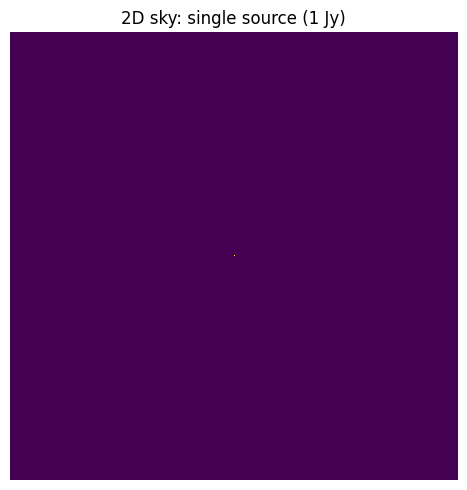

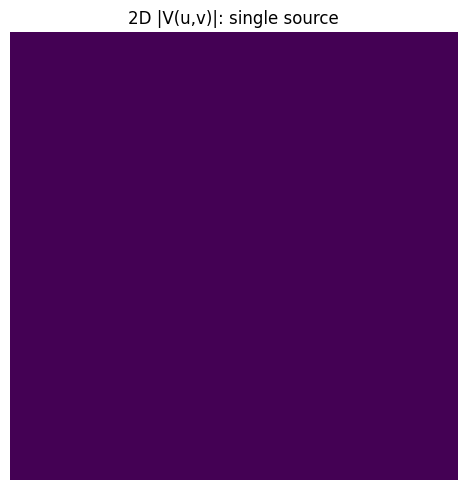

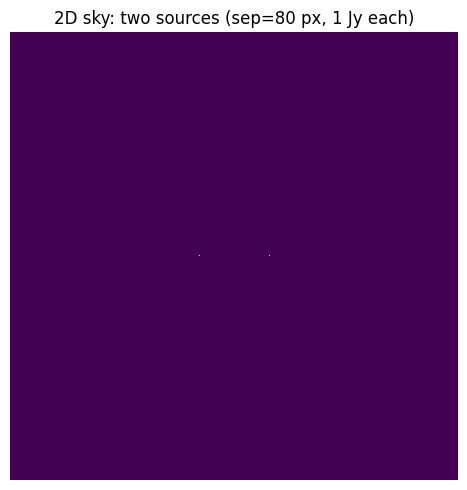

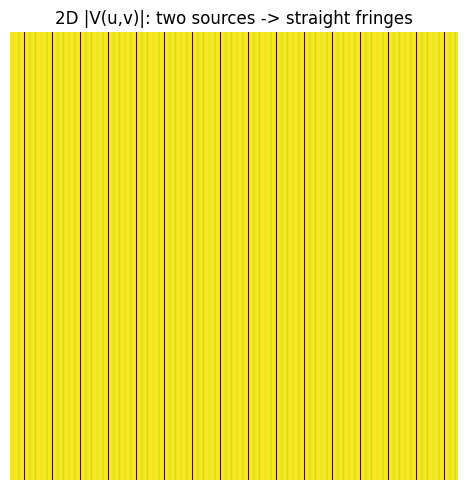

In [14]:
imshow_centered(I2_single, "2D sky: single source (1 Jy)")
imshow_centered(np.abs(V2_single), "2D |V(u,v)|: single source", log=True)
imshow_centered(I2_pair, f"2D sky: two sources (sep={sep_px_2d} px, 1 Jy each)")
imshow_centered(np.abs(V2_pair), "2D |V(u,v)|: two sources -> straight fringes", log=True)